In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import grafteaux as G
from tqdm import tqdm 


### Import PIV data

In [2]:
X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data()
Umean = Prof['U']


current path : C:\Users\Kommalapati sahil\Anaconda3\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


0.2439601862683396


In [3]:
def rf(f):
    '''
    Inverts vector data (f)
    '''
    return [f[len(f)-i-1] for i in range(len(f))]



### Function to generate low-resolution training data

In [4]:
def lowRes(pt, dim):
    '''
    input pt - Field to be converted to lower resolution
    dim - the size of the square tile which does average pooling
    return pt_ - low resolution field. 
    '''
    pt_ = np.zeros(pt.shape)
    for i in range(len(pt)):
        for j in range(len(pt[i])):
            if i< len(pt) and j < len(pt[i]): 
                pt_[i,j] = np.mean(pt[i//dim*dim:i//dim*dim+dim, j//dim*dim: j//dim*dim+dim])
            elif i>= len(pt): pt_[i,j] = np.mean(pt[i//dim*dim:, j//dim*dim: j//dim*dim+dim])
            else:             pt_[i,j] = np.mean(pt[i//dim*dim: i//dim*dim+dim, j//dim*dim:])
    
    return pt_


### Average - pooled low resolution testing

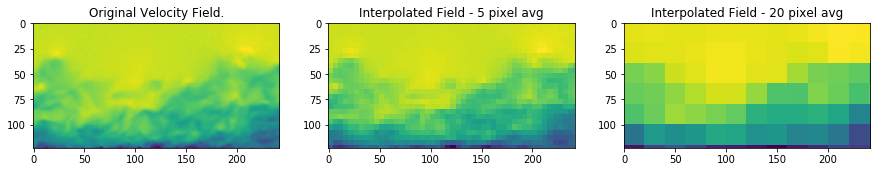

In [5]:
pt = rf(U[:,:,0])
pt2 = lowRes(np.array(pt), 5)
pt3 = lowRes(np.array(pt), 20)


plt.figure(figsize = (15,10))
plt.subplot(1,3,1)
plt.imshow(pt/np.max(pt))
plt.title('Original Velocity Field.')
plt.subplot(1,3,2)
plt.imshow(pt2)
plt.title('Interpolated Field - 5 pixel avg')
plt.subplot(1,3,3)
plt.imshow(pt3)
plt.title('Interpolated Field - 20 pixel avg')
plt.show()

### Generating training data from PIV data

In [6]:
data_ins = []
data_outs = []

dim = 15
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T

for i in tqdm(range(750)):
    
    c_frame = U[:,:,i]-umean2
    c_frame = c_frame/np.nanmax(c_frame)
    
    do = (c_frame).flatten()
    di = lowRes(c_frame,5).flatten()
    data_ins.append(np.nan_to_num(di))
    data_outs.append(np.nan_to_num(do))

100%|██████████| 750/750 [04:15<00:00,  2.94it/s]


### Spliting into training and validation data

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data_ins, data_outs, test_size=0.1, shuffle= True)

#### looking at a sample training input and training output

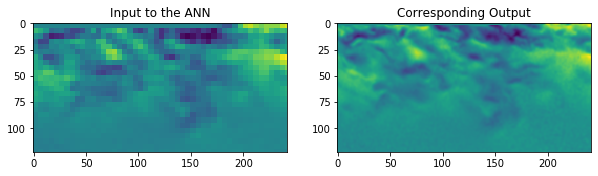

In [8]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(np.array(x_train[0]).reshape(pt2.shape))
plt.title('Input to the ANN')
plt.subplot(1,2,2)
plt.imshow(np.array(y_train[0]).reshape(pt2.shape))
plt.title('Corresponding Output')
plt.show()


### Building the ANN - Keras Sequential Model

In [9]:
#swish activation function - basically relu but better

from tensorflow.keras.backend import sigmoid
from tensorflow.python.keras.utils.generic_utils import get_custom_objects 
from tensorflow.keras.layers import Activation 

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)}) 


### ANN model 

#### Benjamen et al.(2020) Shallow decoder model parameters for forced isotropic turbulence superresolution

In [43]:

from tensorflow.keras import initializers

input_shape = pt2.flatten().shape

model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Dense(350,
                       activation = 'relu',
                       kernel_regularizer = keras.regularizers.l2(1e-7),
                       bias_initializer=initializers.Constant(0.1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(400, 
                       activation='relu',
                       kernel_regularizer = keras.regularizers.l2(1e-7),
                       bias_initializer=initializers.Constant(0.1)),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(0.3),
    keras.layers.Dense(input_shape[0])
])

adam = tf.keras.optimizers.Adam(lr=1e-2,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=None,
                                decay=0.3,
                                amsgrad=False)



In [44]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 350)               10418450  
_________________________________________________________________
batch_normalization_12 (Batc (None, 350)               1400      
_________________________________________________________________
dropout_8 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 400)               140400    
_________________________________________________________________
batch_normalization_13 (Batc (None, 400)               1600      
_________________________________________________________________
dense_20 (Dense)             (None, 29766)             11936166  
Total params: 22,498,016
Trainable params: 22,496,516
Non-trainable params: 1,500
______________________________________

### Compile and fit 

In [45]:

model.compile(optimizer=adam ,
              loss='mean_squared_error',
              metrics=['mse'])

history = model.fit(np.array(x_train),
                    np.array(y_train),
                    shuffle = True,
                    validation_split = 0,
                    epochs=10000,
                    batch_size=200,
                    validation_data = (np.array(x_valid), np.array(y_valid)))



Train on 675 samples, validate on 75 samples
Epoch 1/10000
675/675 [==============================] - 4s 6ms/sample - loss: 0.2376 - mean_squared_error: 0.2374 - val_loss: 5.8968 - val_mean_squared_error: 5.8966
Epoch 2/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0922 - mean_squared_error: 0.0919 - val_loss: 1.6734 - val_mean_squared_error: 1.6731
Epoch 3/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0692 - mean_squared_error: 0.0690 - val_loss: 1.1617 - val_mean_squared_error: 1.1614
Epoch 4/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0526 - mean_squared_error: 0.0523 - val_loss: 0.6540 - val_mean_squared_error: 0.6537
Epoch 5/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0463 - mean_squared_error: 0.0460 - val_loss: 0.4555 - val_mean_squared_error: 0.4552
Epoch 6/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0431 - mean_squared_error: 0.0428 - val

675/675 [==============================] - 2s 3ms/sample - loss: 0.0294 - mean_squared_error: 0.0291 - val_loss: 0.0348 - val_mean_squared_error: 0.0345
Epoch 50/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0295 - mean_squared_error: 0.0291 - val_loss: 0.0346 - val_mean_squared_error: 0.0343
Epoch 51/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0291 - mean_squared_error: 0.0288 - val_loss: 0.0344 - val_mean_squared_error: 0.0341
Epoch 52/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0292 - mean_squared_error: 0.0288 - val_loss: 0.0344 - val_mean_squared_error: 0.0340
Epoch 53/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0290 - mean_squared_error: 0.0287 - val_loss: 0.0344 - val_mean_squared_error: 0.0340
Epoch 54/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0290 - mean_squared_error: 0.0286 - val_loss: 0.0342 - val_mean_squared_error: 0.0338
Epoch 5

Epoch 98/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0265 - mean_squared_error: 0.0262 - val_loss: 0.0324 - val_mean_squared_error: 0.0321
Epoch 99/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0263 - mean_squared_error: 0.0260 - val_loss: 0.0324 - val_mean_squared_error: 0.0320
Epoch 100/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0263 - mean_squared_error: 0.0260 - val_loss: 0.0323 - val_mean_squared_error: 0.0320
Epoch 101/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0260 - mean_squared_error: 0.0257 - val_loss: 0.0323 - val_mean_squared_error: 0.0319
Epoch 102/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0261 - mean_squared_error: 0.0258 - val_loss: 0.0323 - val_mean_squared_error: 0.0319
Epoch 103/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0261 - mean_squared_error: 0.0257 - val_loss: 0.0322 - val_mean_squared_er

675/675 [==============================] - 2s 3ms/sample - loss: 0.0249 - mean_squared_error: 0.0245 - val_loss: 0.0313 - val_mean_squared_error: 0.0310
Epoch 147/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0245 - mean_squared_error: 0.0242 - val_loss: 0.0313 - val_mean_squared_error: 0.0310
Epoch 148/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0247 - mean_squared_error: 0.0243 - val_loss: 0.0313 - val_mean_squared_error: 0.0310
Epoch 149/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0246 - mean_squared_error: 0.0242 - val_loss: 0.0313 - val_mean_squared_error: 0.0309
Epoch 150/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0244 - mean_squared_error: 0.0241 - val_loss: 0.0313 - val_mean_squared_error: 0.0309
Epoch 151/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0246 - mean_squared_error: 0.0242 - val_loss: 0.0312 - val_mean_squared_error: 0.0309
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0235 - mean_squared_error: 0.0231 - val_loss: 0.0306 - val_mean_squared_error: 0.0303
Epoch 195/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0233 - mean_squared_error: 0.0230 - val_loss: 0.0306 - val_mean_squared_error: 0.0302
Epoch 196/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0234 - mean_squared_error: 0.0231 - val_loss: 0.0306 - val_mean_squared_error: 0.0302
Epoch 197/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0234 - mean_squared_error: 0.0230 - val_loss: 0.0306 - val_mean_squared_error: 0.0302
Epoch 198/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0233 - mean_squared_error: 0.0230 - val_loss: 0.0306 - val_mean_squared_error: 0.0302
Epoch 199/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0233 - mean_squared_error: 0.0229 - val_loss: 0.0306 - val_mean_squared_error: 0.0302
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0223 - mean_squared_error: 0.0220 - val_loss: 0.0301 - val_mean_squared_error: 0.0297
Epoch 243/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0223 - mean_squared_error: 0.0220 - val_loss: 0.0301 - val_mean_squared_error: 0.0297
Epoch 244/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0224 - mean_squared_error: 0.0221 - val_loss: 0.0301 - val_mean_squared_error: 0.0297
Epoch 245/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0223 - mean_squared_error: 0.0219 - val_loss: 0.0300 - val_mean_squared_error: 0.0297
Epoch 246/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0223 - mean_squared_error: 0.0219 - val_loss: 0.0300 - val_mean_squared_error: 0.0297
Epoch 247/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0224 - mean_squared_error: 0.0221 - val_loss: 0.0300 - val_mean_squared_error: 0.0297
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0217 - mean_squared_error: 0.0213 - val_loss: 0.0296 - val_mean_squared_error: 0.0293
Epoch 291/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0216 - mean_squared_error: 0.0212 - val_loss: 0.0296 - val_mean_squared_error: 0.0293
Epoch 292/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0218 - mean_squared_error: 0.0214 - val_loss: 0.0296 - val_mean_squared_error: 0.0293
Epoch 293/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0217 - mean_squared_error: 0.0213 - val_loss: 0.0296 - val_mean_squared_error: 0.0293
Epoch 294/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0216 - mean_squared_error: 0.0212 - val_loss: 0.0296 - val_mean_squared_error: 0.0293
Epoch 295/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0215 - mean_squared_error: 0.0212 - val_loss: 0.0296 - val_mean_squared_error: 0.0293
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0210 - mean_squared_error: 0.0207 - val_loss: 0.0293 - val_mean_squared_error: 0.0289
Epoch 339/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0210 - mean_squared_error: 0.0207 - val_loss: 0.0293 - val_mean_squared_error: 0.0289
Epoch 340/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0210 - mean_squared_error: 0.0207 - val_loss: 0.0293 - val_mean_squared_error: 0.0289
Epoch 341/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0209 - mean_squared_error: 0.0206 - val_loss: 0.0293 - val_mean_squared_error: 0.0289
Epoch 342/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0209 - mean_squared_error: 0.0205 - val_loss: 0.0293 - val_mean_squared_error: 0.0289
Epoch 343/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0209 - mean_squared_error: 0.0206 - val_loss: 0.0292 - val_mean_squared_error: 0.0289
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0204 - mean_squared_error: 0.0201 - val_loss: 0.0290 - val_mean_squared_error: 0.0286
Epoch 387/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0203 - mean_squared_error: 0.0200 - val_loss: 0.0290 - val_mean_squared_error: 0.0286
Epoch 388/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0204 - mean_squared_error: 0.0200 - val_loss: 0.0290 - val_mean_squared_error: 0.0286
Epoch 389/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0204 - mean_squared_error: 0.0201 - val_loss: 0.0289 - val_mean_squared_error: 0.0286
Epoch 390/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0203 - mean_squared_error: 0.0200 - val_loss: 0.0289 - val_mean_squared_error: 0.0286
Epoch 391/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0202 - mean_squared_error: 0.0198 - val_loss: 0.0289 - val_mean_squared_error: 0.0286
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0199 - mean_squared_error: 0.0195 - val_loss: 0.0287 - val_mean_squared_error: 0.0284
Epoch 435/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0198 - mean_squared_error: 0.0195 - val_loss: 0.0287 - val_mean_squared_error: 0.0284
Epoch 436/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0198 - mean_squared_error: 0.0195 - val_loss: 0.0287 - val_mean_squared_error: 0.0284
Epoch 437/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0198 - mean_squared_error: 0.0195 - val_loss: 0.0287 - val_mean_squared_error: 0.0284
Epoch 438/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0200 - mean_squared_error: 0.0197 - val_loss: 0.0287 - val_mean_squared_error: 0.0284
Epoch 439/10000
675/675 [==============================] - 3s 5ms/sample - loss: 0.0200 - mean_squared_error: 0.0197 - val_loss: 0.0287 - val_mean_squared_error: 0.0283
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0194 - mean_squared_error: 0.0190 - val_loss: 0.0285 - val_mean_squared_error: 0.0281
Epoch 483/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0195 - mean_squared_error: 0.0191 - val_loss: 0.0285 - val_mean_squared_error: 0.0281
Epoch 484/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0195 - mean_squared_error: 0.0192 - val_loss: 0.0285 - val_mean_squared_error: 0.0281
Epoch 485/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0193 - mean_squared_error: 0.0190 - val_loss: 0.0285 - val_mean_squared_error: 0.0281
Epoch 486/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0194 - mean_squared_error: 0.0191 - val_loss: 0.0285 - val_mean_squared_error: 0.0281
Epoch 487/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0193 - mean_squared_error: 0.0190 - val_loss: 0.0285 - val_mean_squared_error: 0.0281
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0190 - mean_squared_error: 0.0186 - val_loss: 0.0283 - val_mean_squared_error: 0.0280
Epoch 531/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0191 - mean_squared_error: 0.0187 - val_loss: 0.0283 - val_mean_squared_error: 0.0280
Epoch 532/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0189 - mean_squared_error: 0.0185 - val_loss: 0.0283 - val_mean_squared_error: 0.0280
Epoch 533/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0190 - mean_squared_error: 0.0187 - val_loss: 0.0283 - val_mean_squared_error: 0.0280
Epoch 534/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0190 - mean_squared_error: 0.0187 - val_loss: 0.0283 - val_mean_squared_error: 0.0280
Epoch 535/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0188 - mean_squared_error: 0.0185 - val_loss: 0.0283 - val_mean_squared_error: 0.0280
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0187 - mean_squared_error: 0.0183 - val_loss: 0.0281 - val_mean_squared_error: 0.0278
Epoch 579/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0186 - mean_squared_error: 0.0183 - val_loss: 0.0281 - val_mean_squared_error: 0.0278
Epoch 580/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0186 - mean_squared_error: 0.0183 - val_loss: 0.0281 - val_mean_squared_error: 0.0278
Epoch 581/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0186 - mean_squared_error: 0.0182 - val_loss: 0.0281 - val_mean_squared_error: 0.0278
Epoch 582/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0187 - mean_squared_error: 0.0184 - val_loss: 0.0281 - val_mean_squared_error: 0.0278
Epoch 583/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0186 - mean_squared_error: 0.0183 - val_loss: 0.0281 - val_mean_squared_error: 0.0278
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0184 - mean_squared_error: 0.0181 - val_loss: 0.0280 - val_mean_squared_error: 0.0277
Epoch 627/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0183 - mean_squared_error: 0.0180 - val_loss: 0.0280 - val_mean_squared_error: 0.0277
Epoch 628/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0183 - mean_squared_error: 0.0180 - val_loss: 0.0280 - val_mean_squared_error: 0.0277
Epoch 629/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0182 - mean_squared_error: 0.0179 - val_loss: 0.0280 - val_mean_squared_error: 0.0276
Epoch 630/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0186 - mean_squared_error: 0.0183 - val_loss: 0.0280 - val_mean_squared_error: 0.0276
Epoch 631/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0184 - mean_squared_error: 0.0180 - val_loss: 0.0280 - val_mean_squared_error: 0.0276
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0180 - mean_squared_error: 0.0177 - val_loss: 0.0278 - val_mean_squared_error: 0.0275
Epoch 675/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0181 - mean_squared_error: 0.0177 - val_loss: 0.0278 - val_mean_squared_error: 0.0275
Epoch 676/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0181 - mean_squared_error: 0.0178 - val_loss: 0.0278 - val_mean_squared_error: 0.0275
Epoch 677/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0179 - mean_squared_error: 0.0176 - val_loss: 0.0278 - val_mean_squared_error: 0.0275
Epoch 678/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0179 - mean_squared_error: 0.0176 - val_loss: 0.0278 - val_mean_squared_error: 0.0275
Epoch 679/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0181 - mean_squared_error: 0.0177 - val_loss: 0.0278 - val_mean_squared_error: 0.0275
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0176 - mean_squared_error: 0.0173 - val_loss: 0.0277 - val_mean_squared_error: 0.0274
Epoch 723/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0178 - mean_squared_error: 0.0175 - val_loss: 0.0277 - val_mean_squared_error: 0.0274
Epoch 724/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0177 - mean_squared_error: 0.0174 - val_loss: 0.0277 - val_mean_squared_error: 0.0274
Epoch 725/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0176 - mean_squared_error: 0.0173 - val_loss: 0.0277 - val_mean_squared_error: 0.0274
Epoch 726/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0178 - mean_squared_error: 0.0174 - val_loss: 0.0277 - val_mean_squared_error: 0.0274
Epoch 727/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0178 - mean_squared_error: 0.0174 - val_loss: 0.0277 - val_mean_squared_error: 0.0274
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0173 - mean_squared_error: 0.0170 - val_loss: 0.0276 - val_mean_squared_error: 0.0273
Epoch 771/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0174 - mean_squared_error: 0.0171 - val_loss: 0.0276 - val_mean_squared_error: 0.0273
Epoch 772/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0175 - mean_squared_error: 0.0171 - val_loss: 0.0276 - val_mean_squared_error: 0.0273
Epoch 773/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0175 - mean_squared_error: 0.0171 - val_loss: 0.0276 - val_mean_squared_error: 0.0273
Epoch 774/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0174 - mean_squared_error: 0.0170 - val_loss: 0.0276 - val_mean_squared_error: 0.0273
Epoch 775/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0174 - mean_squared_error: 0.0170 - val_loss: 0.0276 - val_mean_squared_error: 0.0273
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0174 - mean_squared_error: 0.0170 - val_loss: 0.0275 - val_mean_squared_error: 0.0272
Epoch 819/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0174 - mean_squared_error: 0.0171 - val_loss: 0.0275 - val_mean_squared_error: 0.0272
Epoch 820/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0171 - mean_squared_error: 0.0168 - val_loss: 0.0275 - val_mean_squared_error: 0.0272
Epoch 821/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0173 - mean_squared_error: 0.0169 - val_loss: 0.0275 - val_mean_squared_error: 0.0271
Epoch 822/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0172 - mean_squared_error: 0.0169 - val_loss: 0.0275 - val_mean_squared_error: 0.0271
Epoch 823/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0173 - mean_squared_error: 0.0169 - val_loss: 0.0275 - val_mean_squared_error: 0.0271
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0169 - mean_squared_error: 0.0166 - val_loss: 0.0274 - val_mean_squared_error: 0.0271
Epoch 867/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0170 - mean_squared_error: 0.0166 - val_loss: 0.0274 - val_mean_squared_error: 0.0271
Epoch 868/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0171 - mean_squared_error: 0.0168 - val_loss: 0.0274 - val_mean_squared_error: 0.0270
Epoch 869/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0171 - mean_squared_error: 0.0167 - val_loss: 0.0274 - val_mean_squared_error: 0.0270
Epoch 870/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0169 - mean_squared_error: 0.0166 - val_loss: 0.0274 - val_mean_squared_error: 0.0270
Epoch 871/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0170 - mean_squared_error: 0.0167 - val_loss: 0.0274 - val_mean_squared_error: 0.0270
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0168 - mean_squared_error: 0.0164 - val_loss: 0.0273 - val_mean_squared_error: 0.0270
Epoch 915/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0171 - mean_squared_error: 0.0167 - val_loss: 0.0273 - val_mean_squared_error: 0.0270
Epoch 916/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0168 - mean_squared_error: 0.0165 - val_loss: 0.0273 - val_mean_squared_error: 0.0270
Epoch 917/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0168 - mean_squared_error: 0.0164 - val_loss: 0.0273 - val_mean_squared_error: 0.0270
Epoch 918/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0168 - mean_squared_error: 0.0165 - val_loss: 0.0273 - val_mean_squared_error: 0.0270
Epoch 919/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0168 - mean_squared_error: 0.0165 - val_loss: 0.0273 - val_mean_squared_error: 0.0270
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0166 - mean_squared_error: 0.0163 - val_loss: 0.0272 - val_mean_squared_error: 0.0269
Epoch 963/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0165 - mean_squared_error: 0.0162 - val_loss: 0.0272 - val_mean_squared_error: 0.0269
Epoch 964/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0165 - mean_squared_error: 0.0162 - val_loss: 0.0272 - val_mean_squared_error: 0.0269
Epoch 965/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0165 - mean_squared_error: 0.0162 - val_loss: 0.0272 - val_mean_squared_error: 0.0269
Epoch 966/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0167 - mean_squared_error: 0.0164 - val_loss: 0.0272 - val_mean_squared_error: 0.0269
Epoch 967/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0167 - mean_squared_error: 0.0163 - val_loss: 0.0272 - val_mean_squared_error: 0.0269
Ep

675/675 [==============================] - 2s 3ms/sample - loss: 0.0163 - mean_squared_error: 0.0160 - val_loss: 0.0271 - val_mean_squared_error: 0.0268
Epoch 1011/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0165 - mean_squared_error: 0.0162 - val_loss: 0.0271 - val_mean_squared_error: 0.0268
Epoch 1012/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0166 - mean_squared_error: 0.0163 - val_loss: 0.0271 - val_mean_squared_error: 0.0268
Epoch 1013/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0165 - mean_squared_error: 0.0162 - val_loss: 0.0271 - val_mean_squared_error: 0.0268
Epoch 1014/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0164 - mean_squared_error: 0.0160 - val_loss: 0.0271 - val_mean_squared_error: 0.0268
Epoch 1015/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0165 - mean_squared_error: 0.0162 - val_loss: 0.0271 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0162 - mean_squared_error: 0.0158 - val_loss: 0.0270 - val_mean_squared_error: 0.0267
Epoch 1059/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0162 - mean_squared_error: 0.0158 - val_loss: 0.0270 - val_mean_squared_error: 0.0267
Epoch 1060/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0162 - mean_squared_error: 0.0159 - val_loss: 0.0270 - val_mean_squared_error: 0.0267
Epoch 1061/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0163 - mean_squared_error: 0.0159 - val_loss: 0.0270 - val_mean_squared_error: 0.0267
Epoch 1062/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0162 - mean_squared_error: 0.0159 - val_loss: 0.0270 - val_mean_squared_error: 0.0267
Epoch 1063/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0163 - mean_squared_error: 0.0160 - val_loss: 0.0270 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0161 - mean_squared_error: 0.0158 - val_loss: 0.0269 - val_mean_squared_error: 0.0266
Epoch 1107/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0160 - mean_squared_error: 0.0157 - val_loss: 0.0269 - val_mean_squared_error: 0.0266
Epoch 1108/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0161 - mean_squared_error: 0.0157 - val_loss: 0.0269 - val_mean_squared_error: 0.0266
Epoch 1109/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0160 - mean_squared_error: 0.0157 - val_loss: 0.0270 - val_mean_squared_error: 0.0266
Epoch 1110/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0162 - mean_squared_error: 0.0159 - val_loss: 0.0270 - val_mean_squared_error: 0.0266
Epoch 1111/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0161 - mean_squared_error: 0.0158 - val_loss: 0.0270 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0158 - mean_squared_error: 0.0155 - val_loss: 0.0269 - val_mean_squared_error: 0.0266
Epoch 1155/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0159 - mean_squared_error: 0.0156 - val_loss: 0.0269 - val_mean_squared_error: 0.0266
Epoch 1156/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0159 - mean_squared_error: 0.0156 - val_loss: 0.0269 - val_mean_squared_error: 0.0266
Epoch 1157/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0160 - mean_squared_error: 0.0157 - val_loss: 0.0269 - val_mean_squared_error: 0.0266
Epoch 1158/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0160 - mean_squared_error: 0.0157 - val_loss: 0.0269 - val_mean_squared_error: 0.0266
Epoch 1159/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0158 - mean_squared_error: 0.0155 - val_loss: 0.0269 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0158 - mean_squared_error: 0.0155 - val_loss: 0.0268 - val_mean_squared_error: 0.0265
Epoch 1203/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0158 - mean_squared_error: 0.0154 - val_loss: 0.0268 - val_mean_squared_error: 0.0265
Epoch 1204/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0157 - mean_squared_error: 0.0154 - val_loss: 0.0268 - val_mean_squared_error: 0.0265
Epoch 1205/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0158 - mean_squared_error: 0.0155 - val_loss: 0.0269 - val_mean_squared_error: 0.0265
Epoch 1206/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0157 - mean_squared_error: 0.0154 - val_loss: 0.0269 - val_mean_squared_error: 0.0265
Epoch 1207/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0158 - mean_squared_error: 0.0155 - val_loss: 0.0268 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0157 - mean_squared_error: 0.0154 - val_loss: 0.0268 - val_mean_squared_error: 0.0265
Epoch 1251/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0156 - mean_squared_error: 0.0153 - val_loss: 0.0268 - val_mean_squared_error: 0.0265
Epoch 1252/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0158 - mean_squared_error: 0.0155 - val_loss: 0.0268 - val_mean_squared_error: 0.0265
Epoch 1253/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0158 - mean_squared_error: 0.0155 - val_loss: 0.0268 - val_mean_squared_error: 0.0265
Epoch 1254/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0156 - mean_squared_error: 0.0152 - val_loss: 0.0268 - val_mean_squared_error: 0.0264
Epoch 1255/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0156 - mean_squared_error: 0.0153 - val_loss: 0.0268 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0155 - mean_squared_error: 0.0152 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 1299/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0155 - mean_squared_error: 0.0152 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 1300/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0155 - mean_squared_error: 0.0152 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 1301/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0156 - mean_squared_error: 0.0152 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 1302/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0154 - mean_squared_error: 0.0151 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 1303/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0155 - mean_squared_error: 0.0151 - val_loss: 0.0267 - val_mean_squared_error: 0.02

675/675 [==============================] - 3s 4ms/sample - loss: 0.0154 - mean_squared_error: 0.0150 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 1347/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0156 - mean_squared_error: 0.0153 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 1348/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0153 - mean_squared_error: 0.0150 - val_loss: 0.0267 - val_mean_squared_error: 0.0264
Epoch 1349/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0155 - mean_squared_error: 0.0152 - val_loss: 0.0267 - val_mean_squared_error: 0.0263
Epoch 1350/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0153 - mean_squared_error: 0.0150 - val_loss: 0.0267 - val_mean_squared_error: 0.0263
Epoch 1351/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0154 - mean_squared_error: 0.0151 - val_loss: 0.0267 - val_mean_squared_error: 0.02

675/675 [==============================] - 3s 4ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0266 - val_mean_squared_error: 0.0263
Epoch 1395/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0153 - mean_squared_error: 0.0150 - val_loss: 0.0266 - val_mean_squared_error: 0.0263
Epoch 1396/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0152 - mean_squared_error: 0.0149 - val_loss: 0.0266 - val_mean_squared_error: 0.0263
Epoch 1397/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0153 - mean_squared_error: 0.0150 - val_loss: 0.0266 - val_mean_squared_error: 0.0263
Epoch 1398/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0266 - val_mean_squared_error: 0.0263
Epoch 1399/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0154 - mean_squared_error: 0.0151 - val_loss: 0.0266 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 4ms/sample - loss: 0.0153 - mean_squared_error: 0.0150 - val_loss: 0.0266 - val_mean_squared_error: 0.0262
Epoch 1443/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0266 - val_mean_squared_error: 0.0262
Epoch 1444/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0266 - val_mean_squared_error: 0.0262
Epoch 1445/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0266 - val_mean_squared_error: 0.0262
Epoch 1446/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0266 - val_mean_squared_error: 0.0262
Epoch 1447/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0266 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 4ms/sample - loss: 0.0151 - mean_squared_error: 0.0147 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1491/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0150 - mean_squared_error: 0.0146 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1492/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0150 - mean_squared_error: 0.0147 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1493/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0150 - mean_squared_error: 0.0147 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1494/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0150 - mean_squared_error: 0.0147 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1495/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0265 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0150 - mean_squared_error: 0.0147 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1539/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1540/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0150 - mean_squared_error: 0.0147 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1541/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1542/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0149 - mean_squared_error: 0.0146 - val_loss: 0.0265 - val_mean_squared_error: 0.0262
Epoch 1543/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0150 - mean_squared_error: 0.0147 - val_loss: 0.0265 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0149 - mean_squared_error: 0.0146 - val_loss: 0.0264 - val_mean_squared_error: 0.0261
Epoch 1587/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0149 - mean_squared_error: 0.0146 - val_loss: 0.0264 - val_mean_squared_error: 0.0261
Epoch 1588/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0149 - mean_squared_error: 0.0146 - val_loss: 0.0264 - val_mean_squared_error: 0.0261
Epoch 1589/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0148 - mean_squared_error: 0.0144 - val_loss: 0.0264 - val_mean_squared_error: 0.0261
Epoch 1590/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0148 - mean_squared_error: 0.0145 - val_loss: 0.0264 - val_mean_squared_error: 0.0261
Epoch 1591/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0151 - mean_squared_error: 0.0148 - val_loss: 0.0264 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0147 - mean_squared_error: 0.0143 - val_loss: 0.0264 - val_mean_squared_error: 0.0261
Epoch 1635/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0149 - mean_squared_error: 0.0146 - val_loss: 0.0264 - val_mean_squared_error: 0.0261
Epoch 1636/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0147 - mean_squared_error: 0.0144 - val_loss: 0.0264 - val_mean_squared_error: 0.0261
Epoch 1637/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0148 - mean_squared_error: 0.0145 - val_loss: 0.0264 - val_mean_squared_error: 0.0260
Epoch 1638/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0147 - mean_squared_error: 0.0144 - val_loss: 0.0264 - val_mean_squared_error: 0.0260
Epoch 1639/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0148 - mean_squared_error: 0.0145 - val_loss: 0.0264 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 4ms/sample - loss: 0.0146 - mean_squared_error: 0.0143 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1683/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0148 - mean_squared_error: 0.0144 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1684/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0147 - mean_squared_error: 0.0143 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1685/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0147 - mean_squared_error: 0.0143 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1686/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0145 - mean_squared_error: 0.0142 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1687/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0147 - mean_squared_error: 0.0143 - val_loss: 0.0263 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0147 - mean_squared_error: 0.0144 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1731/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0147 - mean_squared_error: 0.0144 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1732/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0145 - mean_squared_error: 0.0141 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1733/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0146 - mean_squared_error: 0.0143 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1734/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0146 - mean_squared_error: 0.0143 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1735/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0145 - mean_squared_error: 0.0142 - val_loss: 0.0263 - val_mean_squared_error: 0.02

675/675 [==============================] - 3s 4ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1779/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0145 - mean_squared_error: 0.0142 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1780/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0145 - mean_squared_error: 0.0142 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1781/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1782/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0147 - mean_squared_error: 0.0144 - val_loss: 0.0263 - val_mean_squared_error: 0.0260
Epoch 1783/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0145 - mean_squared_error: 0.0141 - val_loss: 0.0263 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1827/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0146 - mean_squared_error: 0.0143 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1828/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1829/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1830/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0144 - mean_squared_error: 0.0140 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1831/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0262 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1875/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1876/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0142 - mean_squared_error: 0.0139 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1877/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1878/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1879/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0262 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1923/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1924/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0142 - mean_squared_error: 0.0138 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1925/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0262 - val_mean_squared_error: 0.0258
Epoch 1926/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0262 - val_mean_squared_error: 0.0259
Epoch 1927/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0144 - mean_squared_error: 0.0141 - val_loss: 0.0262 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0142 - mean_squared_error: 0.0139 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 1971/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0145 - mean_squared_error: 0.0141 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 1972/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 1973/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 1974/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0139 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 1975/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0261 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0140 - mean_squared_error: 0.0137 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2019/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0140 - mean_squared_error: 0.0137 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2020/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0140 - mean_squared_error: 0.0137 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2021/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0142 - mean_squared_error: 0.0139 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2022/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2023/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0143 - mean_squared_error: 0.0140 - val_loss: 0.0261 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0141 - mean_squared_error: 0.0138 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2067/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0142 - mean_squared_error: 0.0139 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2068/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0141 - mean_squared_error: 0.0138 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2069/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2070/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0142 - mean_squared_error: 0.0138 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 2071/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0140 - mean_squared_error: 0.0136 - val_loss: 0.0261 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0261 - val_mean_squared_error: 0.0257
Epoch 2115/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0261 - val_mean_squared_error: 0.0257
Epoch 2116/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0141 - mean_squared_error: 0.0138 - val_loss: 0.0261 - val_mean_squared_error: 0.0257
Epoch 2117/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0141 - mean_squared_error: 0.0138 - val_loss: 0.0261 - val_mean_squared_error: 0.0257
Epoch 2118/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0140 - mean_squared_error: 0.0137 - val_loss: 0.0261 - val_mean_squared_error: 0.0257
Epoch 2119/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0261 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0140 - mean_squared_error: 0.0137 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2163/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0141 - mean_squared_error: 0.0138 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2164/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0140 - mean_squared_error: 0.0136 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2165/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2166/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0140 - mean_squared_error: 0.0137 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2167/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2211/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2212/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2213/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2214/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2215/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0260 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2259/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2260/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2261/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2262/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2263/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2307/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0133 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2308/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0139 - mean_squared_error: 0.0136 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2309/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0133 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2310/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0260 - val_mean_squared_error: 0.0257
Epoch 2311/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0140 - mean_squared_error: 0.0137 - val_loss: 0.0260 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2355/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2356/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0260 - val_mean_squared_error: 0.0256
Epoch 2357/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0260 - val_mean_squared_error: 0.0256
Epoch 2358/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0260 - val_mean_squared_error: 0.0256
Epoch 2359/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0260 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2403/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2404/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2405/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2406/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2407/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0259 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2451/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0132 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2452/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2453/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2454/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2455/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2499/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2500/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2501/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2502/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0132 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2503/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2547/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2548/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2549/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2550/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0259 - val_mean_squared_error: 0.0256
Epoch 2551/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0259 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2595/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0138 - mean_squared_error: 0.0135 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2596/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2597/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0133 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2598/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0133 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2599/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0137 - mean_squared_error: 0.0134 - val_loss: 0.0258 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2643/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2644/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0134 - mean_squared_error: 0.0130 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2645/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0133 - mean_squared_error: 0.0130 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2646/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2647/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0136 - mean_squared_error: 0.0132 - val_loss: 0.0258 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2691/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0133 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2692/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2693/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0133 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2694/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0133 - mean_squared_error: 0.0130 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2695/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0134 - mean_squared_error: 0.0130 - val_loss: 0.0258 - val_mean_squared_error: 0.02

675/675 [==============================] - 3s 4ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2739/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2740/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2741/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0135 - mean_squared_error: 0.0132 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2742/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0133 - mean_squared_error: 0.0130 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2743/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0133 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2787/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2788/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2789/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2790/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0258 - val_mean_squared_error: 0.0255
Epoch 2791/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0258 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0258 - val_mean_squared_error: 0.0254
Epoch 2835/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2836/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0134 - mean_squared_error: 0.0131 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2837/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2838/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2839/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 3s 4ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2883/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2884/10000
675/675 [==============================] - 3s 5ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2885/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2886/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2887/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 3s 4ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2931/10000
675/675 [==============================] - 3s 5ms/sample - loss: 0.0133 - mean_squared_error: 0.0130 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2932/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0131 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2933/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2934/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0133 - mean_squared_error: 0.0130 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2935/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2979/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2980/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2981/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2982/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 2983/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3027/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3028/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3029/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3030/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3031/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0132 - mean_squared_error: 0.0129 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3075/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3076/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3077/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3078/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3079/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3123/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3124/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3125/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3126/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3127/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3171/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3172/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3173/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0254
Epoch 3174/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.0253
Epoch 3175/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0125 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3219/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0131 - mean_squared_error: 0.0128 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3220/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3221/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3222/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3223/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0126 - val_loss: 0.0257 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3267/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3268/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3269/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3270/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3271/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3315/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3316/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3317/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3318/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3319/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3363/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3364/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3365/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3366/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3367/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3411/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3412/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0130 - mean_squared_error: 0.0127 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3413/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0129 - mean_squared_error: 0.0126 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3414/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3415/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3459/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3460/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3461/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3462/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3463/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3507/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3508/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3509/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3510/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3511/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3555/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3556/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3557/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3558/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3559/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0122 - val_loss: 0.0256 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3603/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.0252
Epoch 3604/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3605/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0122 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 3606/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0256 - val_mean_squared_error: 0.0252
Epoch 3607/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0125 - val_loss: 0.0256 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3651/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3652/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0129 - mean_squared_error: 0.0125 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3653/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3654/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3655/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3699/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3700/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3701/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3702/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3703/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3747/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3748/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3749/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3750/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3751/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3795/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3796/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3797/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3798/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3799/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0127 - mean_squared_error: 0.0124 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3843/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3844/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3845/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3846/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3847/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3891/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0128 - mean_squared_error: 0.0124 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3892/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3893/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3894/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3895/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3939/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3940/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3941/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3942/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3943/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3987/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3988/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3989/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3990/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 3991/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 3s 4ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 4035/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 4036/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 4037/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4038/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 4039/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 4083/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0126 - mean_squared_error: 0.0123 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 4084/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 4085/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 4086/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0252
Epoch 4087/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0255 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 4131/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0121 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 4132/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 4133/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4134/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4135/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4179/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4180/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4181/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4182/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4183/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4227/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4228/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4229/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4230/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4231/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4275/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4276/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4277/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4278/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4279/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4323/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0124 - mean_squared_error: 0.0121 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4324/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4325/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4326/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4327/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0125 - mean_squared_error: 0.0122 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4371/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4372/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4373/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4374/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4375/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4419/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4420/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4421/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4422/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4423/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4467/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4468/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0120 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4469/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4470/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4471/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4515/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4516/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4517/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4518/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4519/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4563/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4564/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4565/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4566/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4567/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 3s 4ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4611/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4612/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4613/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4614/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4615/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4659/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4660/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4661/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4662/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0254 - val_mean_squared_error: 0.0251
Epoch 4663/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0254 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4707/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0123 - mean_squared_error: 0.0119 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4708/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4709/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4710/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4711/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4755/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4756/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4757/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4758/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4759/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4803/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4804/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4805/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4806/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4807/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4851/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4852/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4853/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4854/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4855/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4899/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4900/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4901/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4902/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4903/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4947/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4948/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4949/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4950/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4951/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4995/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4996/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4997/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4998/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 4999/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5043/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5044/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5045/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5046/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5047/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5091/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5092/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5093/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0117 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5094/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0119 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5095/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5139/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5140/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5141/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5142/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5143/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5187/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5188/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5189/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5190/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5191/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5235/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5236/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0121 - mean_squared_error: 0.0118 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 5237/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 5238/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 5239/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5283/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5284/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5285/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5286/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 5287/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5331/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5332/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 5333/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 5334/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 5335/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 5379/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 5380/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0120 - mean_squared_error: 0.0116 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5381/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5382/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5383/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5427/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5428/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5429/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5430/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5431/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5475/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5476/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5477/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5478/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5479/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5523/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5524/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5525/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5526/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5527/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5571/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5572/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5573/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5574/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5575/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5619/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5620/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5621/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5622/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5623/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5667/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5668/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5669/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5670/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5671/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0119 - mean_squared_error: 0.0116 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5715/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5716/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5717/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5718/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5719/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5763/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5764/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5765/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5766/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5767/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5811/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5812/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5813/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5814/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5815/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5859/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5860/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5861/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5862/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5863/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5907/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5908/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5909/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5910/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5911/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5955/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5956/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5957/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5958/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 5959/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6003/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6004/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6005/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6006/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6007/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6051/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6052/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0118 - mean_squared_error: 0.0115 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6053/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6054/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6055/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6099/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6100/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6101/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6102/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6103/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6147/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6148/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6149/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6150/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6151/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0248
Epoch 6195/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0248
Epoch 6196/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0248
Epoch 6197/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0117 - mean_squared_error: 0.0114 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6198/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6199/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6243/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6244/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6245/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6246/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6247/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6291/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6292/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0116 - mean_squared_error: 0.0113 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6293/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6294/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6295/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6339/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6340/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6341/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6342/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6343/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0248
Epoch 6387/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0248
Epoch 6388/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6389/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 6390/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0252 - val_mean_squared_error: 0.0248
Epoch 6391/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0252 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6435/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6436/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6437/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6438/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6439/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6483/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6484/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6485/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6486/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6487/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 4ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6531/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6532/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6533/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6534/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6535/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6579/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6580/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6581/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6582/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6583/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6627/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6628/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6629/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6630/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6631/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6675/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6676/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6677/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6678/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6679/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6723/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6724/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6725/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6726/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6727/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6771/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6772/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6773/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6774/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6775/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6819/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6820/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6821/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6822/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6823/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6867/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6868/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6869/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6870/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6871/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6915/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6916/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6917/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6918/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6919/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6963/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6964/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6965/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6966/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 6967/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7011/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7012/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7013/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7014/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7015/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7059/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7060/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7061/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7062/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7063/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7107/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7108/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7109/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7110/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7111/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7155/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7156/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7157/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7158/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7159/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7203/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7204/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0115 - mean_squared_error: 0.0112 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7205/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7206/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0114 - mean_squared_error: 0.0111 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7207/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7251/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7252/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7253/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7254/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7255/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7299/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7300/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7301/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7302/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7303/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7347/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7348/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7349/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7350/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7351/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0247
Epoch 7395/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.0247
Epoch 7396/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7397/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7398/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7399/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7443/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7444/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7445/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7446/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0251 - val_mean_squared_error: 0.0248
Epoch 7447/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0251 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7491/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7492/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7493/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7494/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7495/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7539/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7540/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7541/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7542/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7543/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7587/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7588/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7589/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7590/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7591/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7635/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7636/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7637/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7638/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7639/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7683/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7684/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7685/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7686/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7687/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7731/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7732/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7733/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7734/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7735/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7779/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7780/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7781/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7782/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7783/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7827/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7828/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7829/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7830/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7831/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7875/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7876/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7877/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7878/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7879/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7923/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7924/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7925/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7926/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7927/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7971/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7972/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7973/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7974/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 7975/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8019/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8020/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8021/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8022/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8023/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0113 - mean_squared_error: 0.0110 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8067/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8068/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8069/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8070/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8071/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8115/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8116/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8117/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8118/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8119/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8163/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8164/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8165/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8166/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8167/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8211/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8212/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8213/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8214/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8215/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8259/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8260/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0112 - mean_squared_error: 0.0109 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8261/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8262/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8263/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8307/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8308/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8309/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8310/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8311/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8355/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8356/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8357/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8358/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8359/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8403/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8404/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8405/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8406/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8407/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8451/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8452/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8453/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8454/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8455/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8499/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8500/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8501/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8502/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8503/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8547/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8548/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8549/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8550/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8551/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8595/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8596/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8597/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8598/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8599/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8643/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8644/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8645/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8646/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8647/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8691/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8692/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8693/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8694/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8695/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8739/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8740/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8741/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8742/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8743/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8787/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0111 - mean_squared_error: 0.0108 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8788/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8789/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8790/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8791/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8835/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8836/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8837/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8838/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8839/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 4ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8883/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8884/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8885/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8886/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8887/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8931/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8932/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8933/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8934/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8935/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8979/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8980/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8981/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8982/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 8983/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9027/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9028/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9029/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9030/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9031/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9075/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9076/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9077/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9078/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.0247
Epoch 9079/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0250 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9123/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9124/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9125/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9126/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9127/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9171/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9172/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9173/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9174/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9175/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9219/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9220/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9221/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9222/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9223/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9267/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9268/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9269/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9270/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9271/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9315/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9316/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9317/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9318/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9319/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9363/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9364/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9365/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9366/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9367/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9411/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9412/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9413/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9414/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9415/10000
675/675 [==============================] - 3s 4ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9459/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9460/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9461/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9462/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9463/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9507/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9508/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9509/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9510/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9511/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0110 - mean_squared_error: 0.0107 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9555/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9556/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9557/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9558/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9559/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9603/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9604/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9605/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9606/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9607/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9651/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9652/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9653/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9654/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9655/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9699/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9700/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9701/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9702/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9703/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9747/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9748/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9749/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9750/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9751/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9795/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9796/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9797/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9798/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9799/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9843/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9844/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9845/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9846/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9847/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9891/10000
675/675 [==============================] - 2s 4ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9892/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9893/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9894/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0109 - mean_squared_error: 0.0106 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9895/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9939/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9940/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9941/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9942/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9943/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.02

675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9987/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0105 - mean_squared_error: 0.0102 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9988/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9989/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0107 - mean_squared_error: 0.0104 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9990/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0108 - mean_squared_error: 0.0105 - val_loss: 0.0249 - val_mean_squared_error: 0.0246
Epoch 9991/10000
675/675 [==============================] - 2s 3ms/sample - loss: 0.0106 - mean_squared_error: 0.0103 - val_loss: 0.0249 - val_mean_squared_error: 0.02

In [49]:
model.save('C:/Users/Kommalapati sahil/Desktop/Brunton/ANN10k')-

### Training and testing convergence histories

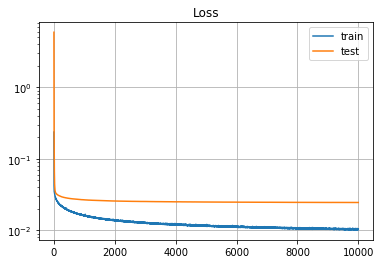

In [46]:

plt.title('Loss')
plt.semilogy(history.history['mean_squared_error'], label='train')
plt.semilogy(history.history['val_mean_squared_error'], label='test')
plt.legend()
plt.grid()
plt.show()

### Reconstructed high resolution Images from ANN 

#### Using Validation cases

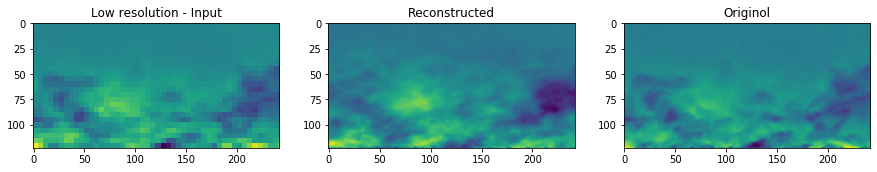

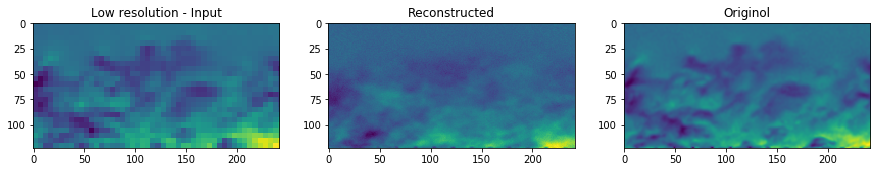

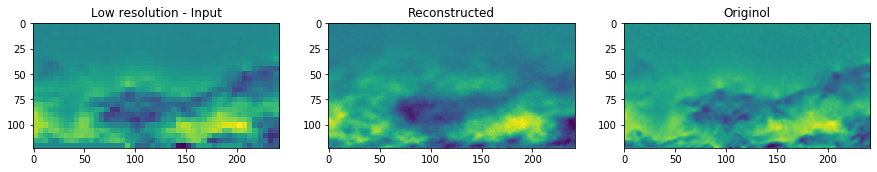

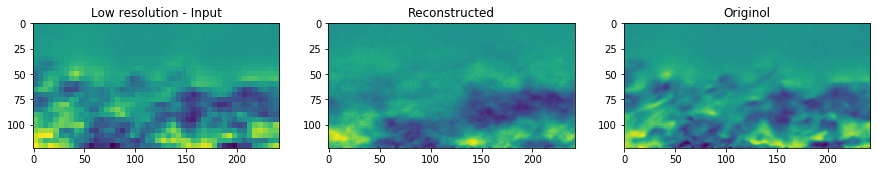

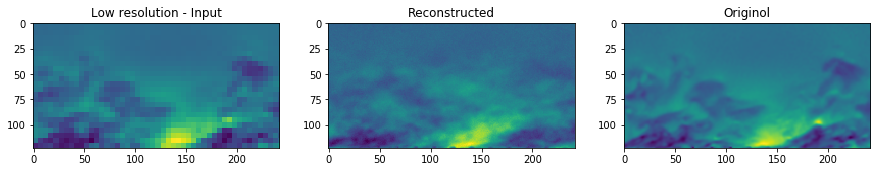

In [47]:
for i in range(5):
    plt.figure(figsize = (15,10))

    plt.subplot(1,3,1)
    plt.imshow(rf(x_valid[i].reshape(pt2.shape)))
    plt.title('Low resolution - Input')
    y_pred0 = model.predict(np.array([x_valid[i]]))

    plt.subplot(1,3,2)
    plt.imshow(rf(y_pred0.reshape(pt2.shape)))
    plt.title('Reconstructed')

    plt.subplot(1,3,3)
    plt.imshow(rf(y_valid[i].reshape(pt2.shape)))
    plt.title('Originol')
    plt.show()